In [1]:
import re
import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [5]:
stop_words = set(stopwords.words("indonesian")) 
def bersihkan_teks(teks):
    teks = teks.lower()
    teks = re.sub(r'\d+', '', teks)
    teks = re.sub(r"http\S+|www\S+|https\S+", "", teks, flags=re.MULTILINE)
    teks = re.sub(r"@\w+|#", "", teks)
    teks = re.sub(r"[^\w\s]", "", teks)
    teks = re.sub(r'<.*?>', '', teks)
    teks = re.sub(r'\s+', ' ', teks).strip()
    teks = " ".join([stemmer.stem(word) for word in teks.split() if word not in stop_words])
    return teks

In [6]:
df = pd.read_csv("dataset_pengaduan.csv")

In [7]:
df['konten'] = df['pengaduan'].apply(bersihkan_teks)
df['pengaduan'] = df['konten']
df.drop(columns=['pengaduan'], inplace=True)

In [8]:
df_classification = df[['konten', 'kategori', 'sentimen']]
df_classification.head()

,konten,kategori,sentimen
0,macet parah area parkir pintu masuk,Transportasi,negatif
1,kualitas ajar turun pustaka pustaka guru tidak...,Pendidikan,positif
2,fasilitas sekolah manajemen buruk minim ruang ...,Pendidikan,negatif
3,sedia obat darurat tidak cukup menit pasien,Kesehatan,positif
4,jadwal bus menit lambat tumpang pagi,Transportasi,netral


# Pre-proccessing Data

## pre-sklearn

Ekstrasi fitur menggunakan TF-IDF untuk menghitung nilai dari kata.

In [9]:
tfidf = TfidfVectorizer()
konten_tfidf = tfidf.fit_transform(df_classification['konten']).toarray()

Mengubah kategori menjadi label agar bisa digabung untuk meningkatkan kualitas training.

In [10]:
ohe = OneHotEncoder()
kategori_encode = ohe.fit_transform(df_classification[['kategori']]).toarray()

Mengubah sentimen menjadi label, agar bisa digunakan untuk prediksi

In [11]:
le = LabelEncoder()
df_classification['sentimen'] = le.fit_transform(df_classification['sentimen'])

<ipython-input-11-97cdb236d769>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_classification['sentimen'] = le.fit_transform(df_classification['sentimen'])


## pre-deep learning

In [12]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df_classification['konten'])
sequencens = tokenizer.texts_to_sequences(df_classification['konten'])

# Split data

## Split for sklearn

In [13]:
X = np.hstack((konten_tfidf, kategori_encode))
y = le.fit_transform(df_classification['sentimen'])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42)

## Split for Deep Learning

In [15]:
lengths = [len(seq) for seq in sequencens]
len_seq = int(np.percentile(lengths, 95))

In [16]:
X_dl = pad_sequences(sequencens, maxlen=len_seq)
y_dl = to_categorical(df_classification['sentimen'])
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_dl,
    y_dl,
    test_size=0.2,
    random_state=42)

# Pembuatan Model

## Model sklearn

In [17]:
model_xgb = XGBClassifier()
model_svc = SVC(kernel='linear', random_state=42)
model_rf = RandomForestClassifier(random_state=42)

## Model Deep Learning menggunakan Tensorflow

In [18]:
model_dl = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=len_seq, name='Input'),
    LSTM(64, dropout=0.1, recurrent_dropout=0.1, return_sequences=True),
    SpatialDropout1D(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01), name='Dense_layer'),
    LSTM(32, dropout=0.1, recurrent_dropout=0.1, return_sequences=False),
    Dropout(0.5),
    Dense(3, activation='softmax', name='predict')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Balancing sentiment

In [19]:
print(df_classification['sentimen'].value_counts())

sentimen
0    9850
2    5978
1    4172
Name: count, dtype: int64


In [20]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_dl.argmax(axis=1)), y=y_train_dl.argmax(axis=1))
class_weight_dict = dict(enumerate(class_weights))

In [21]:
for key in class_weight_dict:
    class_weight_dict[key] = min(class_weight_dict[key], 1.5)

In [22]:
print(class_weight_dict)

{0: np.float64(0.6753619517960406), 1: 1.5, 2: np.float64(1.1157601115760112)}


# Training Model

## Model sklearn

In [23]:
#Training Model XGBoost
model_xgb.fit(X_train, y_train)
y_train_predic_xgb = model_xgb.predict(X_train)
y_test_predic_xgb = model_xgb.predict(X_test)

In [24]:
train_accuracy_xgb = accuracy_score(y_train, y_train_predic_xgb)
test_accuracy_xgb = accuracy_score(y_test, y_test_predic_xgb)

print("XGBoost:\n")
print(f"Akurasi Training: {train_accuracy_xgb:.4f}")
print(f"Akurasi Testing: {test_accuracy_xgb:.4f}")

XGBoost:

Akurasi Training: 0.5157
Akurasi Testing: 0.4720


In [25]:
#Training Model Random Forest
model_rf.fit(X_train, y_train)
y_train_predic_rf = model_rf.predict(X_train)
y_test_predic_rf = model_rf.predict(X_test)

In [26]:
train_accuracy_rf = accuracy_score(y_train, y_train_predic_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_predic_rf)

print("Random Forest:\n")
print(f"Akurasi Training: {train_accuracy_rf:.4f}")
print(f"Akurasi Testing: {test_accuracy_rf:.4f}")

Random Forest:

Akurasi Training: 0.5242
Akurasi Testing: 0.4532


## Model Tensorflow

In [27]:
model_dl.compile(optimizer=AdamW(learning_rate=0.05), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
model_dl.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (Embedding)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_layer (Dense)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predict (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
early_stopping = EarlyStopping(patience=7, restore_best_weights=True, monitor='val_accuracy')

In [30]:
training = model_dl.fit(X_train_dl, y_train_dl, epochs=15, batch_size=64, validation_split=0.2, class_weight=class_weight_dict, callbacks=[early_stopping])

Epoch 1/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - accuracy: 0.3663 - loss: 1.1745 - val_accuracy: 0.2878 - val_loss: 1.1098
Epoch 2/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.3535 - loss: 1.0808 - val_accuracy: 0.2878 - val_loss: 1.1069
Epoch 3/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.3551 - loss: 1.0726 - val_accuracy: 0.2084 - val_loss: 1.1039
Epoch 4/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.3638 - loss: 1.0749 - val_accuracy: 0.5038 - val_loss: 1.0765
Epoch 5/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.3608 - loss: 1.0750 - val_accuracy: 0.2084 - val_loss: 1.0966
Epoch 6/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.3606 - loss: 1.0766 - val_accuracy: 0.2878 - val_loss: 1.0847
Epoch 7/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.3420 - loss: 1.0775 - val_accuracy: 0.2084 - val_loss: 1.1177
Epoch 8/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.3701 - loss: 1.0756 -

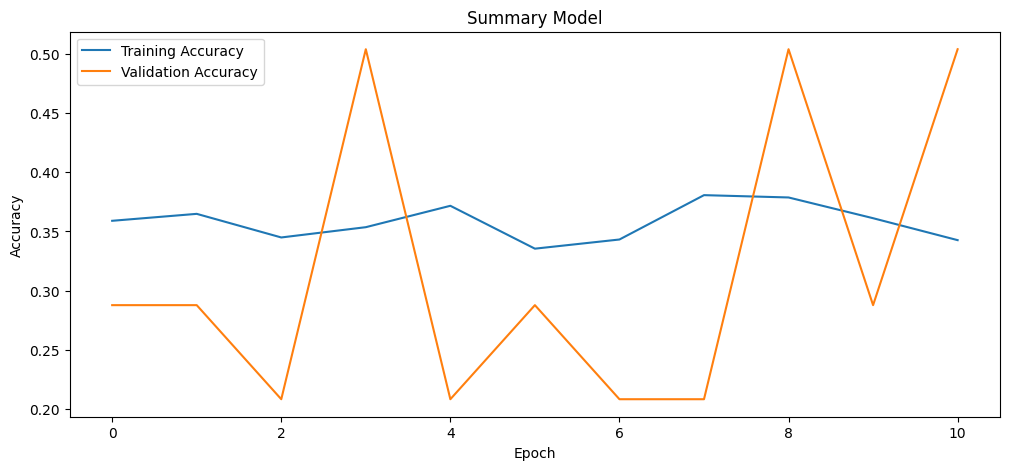

In [31]:
plt.figure(figsize=(12, 5))
plt.plot(training.history['accuracy'], label='Training Accuracy')
plt.plot(training.history['val_accuracy'], label='Validation Accuracy')
plt.title('Summary Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()